# gan
- gan, cgan
- pix2pix

- 숫자 이미지 생성
- 채색

## cGAN
- Conditional Generative Adversarial Nets (cGAN)은 내가 원하는 종류의 이미지를 생성하고자 할 때 GAN이 가진 생성 과정의 불편함을 해소하여,
내가 원하는 종류의 이미지를 생성할 수 있도록 고안된 방법

![](https://aiffelstaticprd.blob.core.windows.net/media/images/cgan_img.max-800x600.png)

## data import
```
 pip install tensorflow-datasets
    ```

In [1]:
# mnist data set

import tensorflow_datasets as tfds

mnist, info =  tfds.load(
    "mnist", split="train", with_info=True
)

fig = tfds.show_examples(mnist, info)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /home/ubuntu/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


ModuleNotFoundError: No module named 'matplotlib'
Failed importing matplotlib.pyplot. This likely means that the dataset requires additional dependencies that have to be manually installed (usually with `pip install matplotlib.pyplot`). See setup.py extras_require.

In [2]:
## data set gan / cgan 용 분리
import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1 # 256  1 ~ -1로 값 조정.
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10) # one hot  label< 적용 
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)
print("✅")

✅


Label : tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


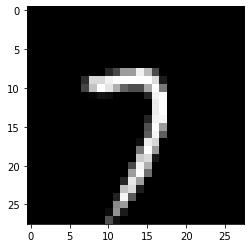

In [4]:
import matplotlib.pyplot as plt

for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.     
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

# generator

## gan generator

In [5]:
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()

        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')

        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

print("✅")

✅


## cgan generartor

In [6]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)
    
print("✅")

✅


# disicriminator

## gan discriminator

In [7]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x) # fc layer 학습 시키기 위해...
        for block in self.blocks:
            x = block(x)
        return x
    
print("✅")

✅


## cGan disicriminator

- maxout : 두 레이어 사이를 연결할 때, 여러 개의 fully-connected 레이어를 통과시켜 그 중 가장 큰 값을 가져오도록
- 24-5

### mxaout

- units 차원의 representatoin을 pieces개만큼 만들고 그 중 최댓 값 1개 차원만 출력

In [8]:
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=1)

print("✅")

✅


- cgan discriminator 는 maxout layer 활용

In [9]:
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)
    
print("✅")

✅


# GAN

## model set
- 찐, 짭 구별을 위해  Binary Cross Entropy를 사용
- adam optimizer이용

- 각 generator / disicirimnator 셋팅

In [10]:
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)    



In [11]:
# 노이즈를 100차원으로 설정
#

In [12]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    # 평균이 100인 이미지 사이즈의 랜덤 난수 생성,..........
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        
        # 각 손실을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
        
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    
    return gene_loss, disc_loss

print("✅")

✅


## train

In [13]:
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/10 EPOCHS, 100 ITER] G:2.171053171157837, D:0.14335843920707703
[1/10 EPOCHS, 200 ITER] G:2.5605318546295166, D:0.1098170280456543
[1/10 EPOCHS, 300 ITER] G:2.791450023651123, D:0.09674517810344696
[1/10 EPOCHS, 400 ITER] G:2.5023233890533447, D:0.1424439251422882
[2/10 EPOCHS, 100 ITER] G:3.8381576538085938, D:0.1021784320473671
[2/10 EPOCHS, 200 ITER] G:2.517451286315918, D:0.4794543981552124
[2/10 EPOCHS, 300 ITER] G:3.0001983642578125, D:0.21052753925323486
[2/10 EPOCHS, 400 ITER] G:4.748301982879639, D:0.08379179239273071
[3/10 EPOCHS, 100 ITER] G:3.091331720352173, D:0.1919446736574173
[3/10 EPOCHS, 200 ITER] G:3.838405132293701, D:0.11126314103603363
[3/10 EPOCHS, 300 ITER] G:2.379279136657715, D:0.18297871947288513
[3/10 EPOCHS, 400 ITER] G:3.9221415519714355, D:0.12404768168926239
[4/10 EPOCHS, 100 ITER] G:4.492813587188721, D:0.1127006784081459
[4/10 EPOCHS, 200 ITER] G:5.085115432739258, D:0.23113234341144562
[4/10 EPOCHS, 300 ITER] G:4.353507041931152, D:0.02815407514572

## test

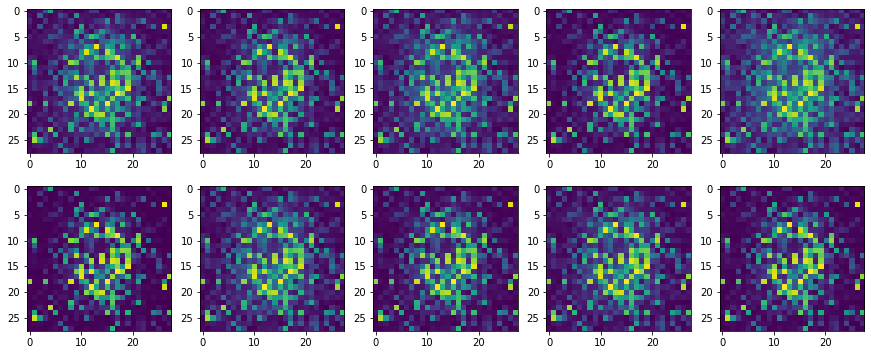

In [14]:
import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

## epoch 500  weight

In [16]:
# 500 epch pretrained model upload
! wget https://aiffelstaticprd.blob.core.windows.net/media/documents/GAN_500.zip

--2020-11-11 18:26:15--  https://aiffelstaticprd.blob.core.windows.net/media/documents/GAN_500.zip
Resolving aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)... 52.239.148.4
Connecting to aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)|52.239.148.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2151851 (2.1M) [application/zip]
Saving to: ‘GAN_500.zip.1’

GAN_500.zip.1       100%[===================>]   2.05M  12.7MB/s    in 0.2s    

2020-11-11 18:26:16 (12.7 MB/s) - ‘GAN_500.zip.1’ saved [2151851/2151851]



In [18]:
import os
weight_path = os.getenv('HOME')+'/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E24-gan_img/GAN_500/GAN_500'
#weight_path ='./GAN_500'

noise = tf.random.normal([10, 100]) 

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

ValueError: Unsuccessful TensorSliceReader constructor: Failed to get matching files on /home/ubuntu/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E24-gan_img/GAN_500/GAN_500: Not found: /home/ubuntu/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E24-gan_img/GAN_500; No such file or directory

# CGAN

In [ ]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

## epoch 500 weight upload

In [23]:
!wget https://aiffelstaticprd.blob.core.windows.net/media/documents/CGAN_500.zip
!unzip CGAN_500.zip

--2020-11-11 18:03:45--  https://aiffelstaticprd.blob.core.windows.net/media/documents/CGAN_500.zip
Resolving aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)... 52.239.148.4
Connecting to aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)|52.239.148.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2579076 (2.5M) [application/zip]
Saving to: ‘CGAN_500.zip.1’

CGAN_500.zip.1      100%[===================>]   2.46M  15.0MB/s    in 0.2s    

2020-11-11 18:03:45 (15.0 MB/s) - ‘CGAN_500.zip.1’ saved [2579076/2579076]

Archive:  CGAN_500.zip
  inflating: CGAN_500.index          
  inflating: CGAN_500.data-00001-of-00002  
  inflating: CGAN_500.data-00000-of-00002  


In [24]:
number =  7 # TODO : 생성할 숫자를 입력해 주세요!!

weight_path = os.getenv('HOME')+'/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E24-gan_img/CGAN/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

InvalidArgumentError: Unsuccessful TensorSliceReader constructor: Failed to get matching files on /home/ubuntu/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E24-gan_img/CGAN/CGAN_500: Not found: /home/ubuntu/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E24-gan_img/CGAN; No such file or directory

# pix2pix_ generator
   
   
- conv 레이어를 통해 이미지 다운 샘플링 representation 학습 -bottleneck
- 다시 conv 레리어로 upsampling , 입력 이미지와 동일한 크기.로 생성.



![](https://aiffelstaticprd.blob.core.windows.net/media/images/p2p_generator.max-800x600.png)

## u-net

- skip connection
- 인토더의 상위 레이어의 결과를 decoder로 연결하여
- 비교적 선명한 결과를 얻을tn
![](https://aiffelstaticprd.blob.core.windows.net/media/images/p2p_generator_unet.max-800x600.png)

## PIX2PIX DISCRIMINATOR
- CONV LAYER   
![](https://aiffelstaticprd.blob.core.windows.net/media/original_images/dcgan_d.png)
![](https://aiffelstaticprd.blob.core.windows.net/media/images/patchgan.max-800x600.png)


- 파란색 점선은 여러 개의 출력 중 하나의 출력을 계산하기 위한 입력이미지의 receptive field 영역을 나타내고 있으며, 전체 영역을 다 보는 것이 아닌 일부 영역(파란색 점선)에 대해서만 진짜/가짜를 판별하는 하나의 확률 값을 도출
   
   
- 이미지의 일부 영역(patch)을 이용한다고 하여 PatchGAN
- 거리가 먼 두 픽셀은 서로 연관성이 거의 없기 때문에 특정 크기를 가진 일부 영역에 대해서 세부적으로 진짜/가짜를 판별하는 것

# 실습 채색

## Sketch2Pokemon DATA SET DONWLOAD
- https://www.kaggle.com/norod78/sketch2pokemon


In [25]:
!wget https://aiffelstaticprd.blob.core.windows.net/media/documents/sketch2pokemon.zip
!unzip sketch2pokemon.zip

--2020-11-11 18:03:46--  https://aiffelstaticprd.blob.core.windows.net/media/documents/sketch2pokemon.zip
Resolving aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)... 52.239.148.4
Connecting to aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)|52.239.148.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66732281 (64M) [application/zip]
Saving to: ‘sketch2pokemon.zip’

sketch2pokemon.zip   75%[==============>     ]  48.29M  12.6MB/s    eta 2s     ^C
Archive:  sketch2pokemon.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of sketch2pokemon.zip or
        sketch2pokemon.zip.zip, and cannot find sketch2pokemon.zip.ZIP, period.


In [26]:
!ls

01-basic-Copy1.ipynb	      CGAN_500.zip
01-basic.ipynb		      CGAN_500.zip.1
02-prj.ipynb		      GAN_500.zip
CGAN_500.data-00000-of-00002  pokemon_pix2pix_dataset
CGAN_500.data-00001-of-00002  sketch2pokemon.zip
CGAN_500.index


## DATA SET IMPORT

In [1]:
import os
#+'/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E24-gan_img/GAN_500/GAN_500'

data_path =  './pokemon_pix2pix_dataset/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 830


In [2]:
!pwd

/home/ubuntu/lsg/AIFFEL_LSG/lms/01-EXPLORATION/E24-gan_img


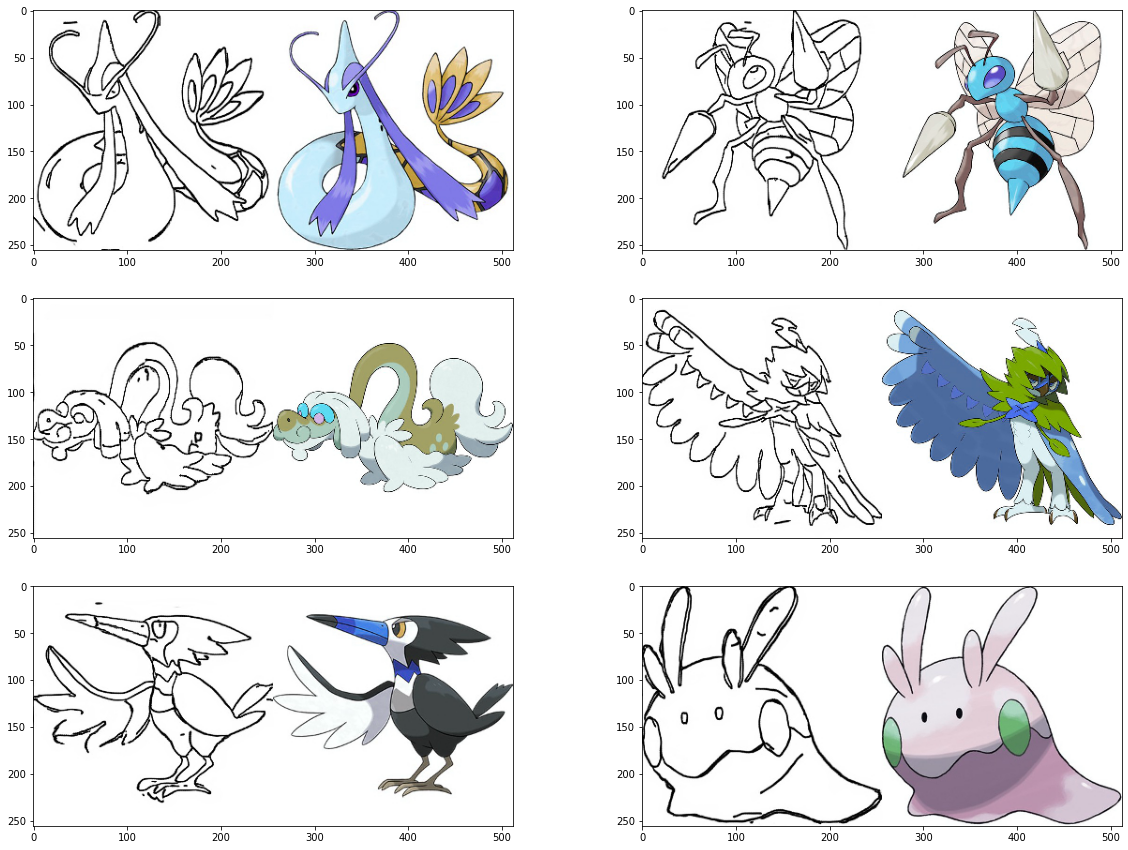

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

## IMG 처리

In [4]:
# 이미지 사이즈

In [5]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


## IMG 분리

In [6]:
# 이미지 분할
# 반타작

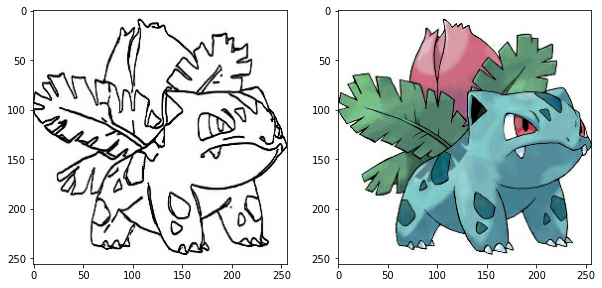

In [7]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

## AUGMENTATION 

In [8]:
# 자르고 위아래, 왼좌 전환, 

from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


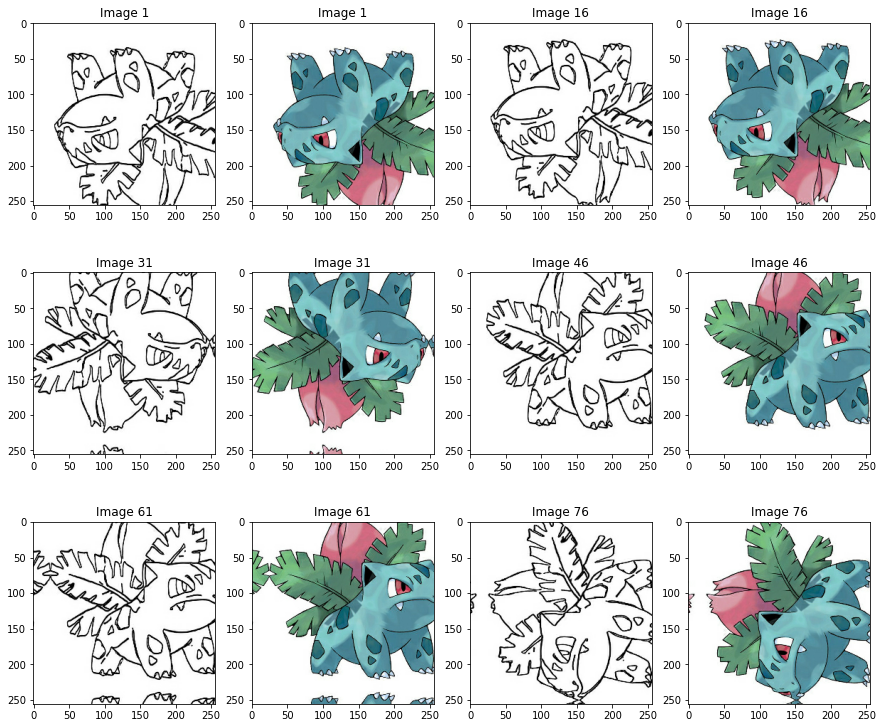

In [9]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 15

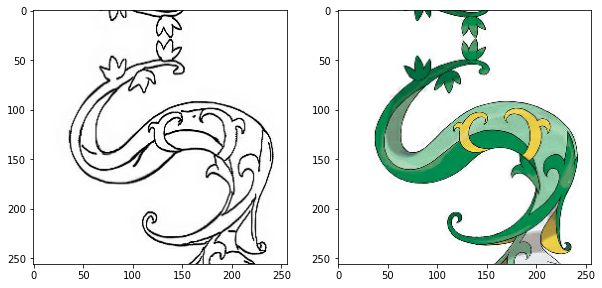

In [10]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

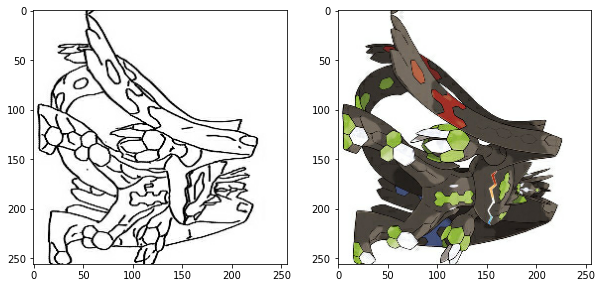

In [11]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## architecture

![](https://aiffelstaticprd.blob.core.windows.net/media/original_images/paper_g.png)

![](https://aiffelstaticprd.blob.core.windows.net/media/images/refer_g.max-800x600.png)

## generator_block ()


```
tf.keras.layers.Conv2D(
    filters, kernel_size, strides=(1, 1), padding='valid', data_format=None,
    dilation_rate=(1, 1), groups=1, activation=None, use_bias=True,
    kernel_initializer='glorot_uniform', bias_initializer='zeros',
    kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    kernel_constraint=None, bias_constraint=None, **kwargs
)
```

In [12]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn: # encoder 첫번째 레이어 배치 놈 안씀.
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


In [13]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512] # 필터(커널) 개수 리스트)
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0: # 첫번째 레이어 배치놈 사용 안함(feat. 논문
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape) # is used to instantiate a Keras tensor
                       
        return Model(inputs, self.call(inputs)).summary()



In [14]:
Encoder().get_summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)        

## decoder_bloack(

In [15]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


In [16]:
Decoder().get_summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)      

## encoder+ decoder

In [17]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


## unet, (skip connection 추가)

### unet - generator

In [18]:
# 요건 그대로임

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [19]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1] # 
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [20]:
UNetGenerator().get_summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
_______________________________________________________________________________________

### unet - discriminator

In [21]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [22]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [23]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [24]:
Discriminator().get_summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]  

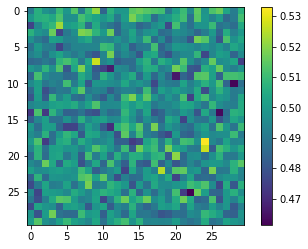

In [25]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## train


In [26]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

# fake_disc는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값
def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [27]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [28]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [29]:
EPOCHS = 100

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:1.0519                     
L1_loss:0.5760                     
Discriminator_loss:1.0361

EPOCH[1] - STEP[20]                     
Generator_loss:0.7473                     
L1_loss:0.3777                     
Discriminator_loss:1.2236

EPOCH[1] - STEP[30]                     
Generator_loss:0.9227                     
L1_loss:0.3157                     
Discriminator_loss:1.2032

EPOCH[1] - STEP[40]                     
Generator_loss:1.7247                     
L1_loss:0.2411                     
Discriminator_loss:1.3141

EPOCH[1] - STEP[50]                     
Generator_loss:1.8798                     
L1_loss:0.2859                     
Discriminator_loss:0.6545

EPOCH[1] - STEP[60]                     
Generator_loss:1.3079                     
L1_loss:0.2226                     
Discriminator_loss:0.8139

EPOCH[1] - STEP[70]                     
Generator_loss:1.8194                     
L1_loss:0.2113                    

EPOCH[3] - STEP[170]                     
Generator_loss:1.5724                     
L1_loss:0.2501                     
Discriminator_loss:1.0583

EPOCH[3] - STEP[180]                     
Generator_loss:1.6789                     
L1_loss:0.2162                     
Discriminator_loss:1.3011

EPOCH[3] - STEP[190]                     
Generator_loss:1.7865                     
L1_loss:0.2849                     
Discriminator_loss:0.4354

EPOCH[3] - STEP[200]                     
Generator_loss:2.7295                     
L1_loss:0.2163                     
Discriminator_loss:0.6062

EPOCH[4] - STEP[10]                     
Generator_loss:2.2007                     
L1_loss:0.2440                     
Discriminator_loss:0.3285

EPOCH[4] - STEP[20]                     
Generator_loss:0.5592                     
L1_loss:0.2558                     
Discriminator_loss:1.0715

EPOCH[4] - STEP[30]                     
Generator_loss:1.3843                     
L1_loss:0.2781                

EPOCH[6] - STEP[130]                     
Generator_loss:1.8499                     
L1_loss:0.2305                     
Discriminator_loss:0.6355

EPOCH[6] - STEP[140]                     
Generator_loss:0.6788                     
L1_loss:0.2564                     
Discriminator_loss:1.0577

EPOCH[6] - STEP[150]                     
Generator_loss:1.4852                     
L1_loss:0.2344                     
Discriminator_loss:1.0829

EPOCH[6] - STEP[160]                     
Generator_loss:2.4439                     
L1_loss:0.2695                     
Discriminator_loss:0.4027

EPOCH[6] - STEP[170]                     
Generator_loss:1.0156                     
L1_loss:0.2743                     
Discriminator_loss:0.5535

EPOCH[6] - STEP[180]                     
Generator_loss:3.2381                     
L1_loss:0.2525                     
Discriminator_loss:2.1482

EPOCH[6] - STEP[190]                     
Generator_loss:0.4512                     
L1_loss:0.2364             

EPOCH[9] - STEP[90]                     
Generator_loss:1.1586                     
L1_loss:0.1982                     
Discriminator_loss:0.5671

EPOCH[9] - STEP[100]                     
Generator_loss:0.4333                     
L1_loss:0.2297                     
Discriminator_loss:1.2194

EPOCH[9] - STEP[110]                     
Generator_loss:1.7276                     
L1_loss:0.2614                     
Discriminator_loss:0.4683

EPOCH[9] - STEP[120]                     
Generator_loss:1.2908                     
L1_loss:0.2323                     
Discriminator_loss:0.4194

EPOCH[9] - STEP[130]                     
Generator_loss:1.2643                     
L1_loss:0.2231                     
Discriminator_loss:0.4687

EPOCH[9] - STEP[140]                     
Generator_loss:1.5484                     
L1_loss:0.2314                     
Discriminator_loss:0.6292

EPOCH[9] - STEP[150]                     
Generator_loss:2.2422                     
L1_loss:0.3010              

EPOCH[12] - STEP[50]                     
Generator_loss:2.5268                     
L1_loss:0.2836                     
Discriminator_loss:0.6047

EPOCH[12] - STEP[60]                     
Generator_loss:2.4794                     
L1_loss:0.2577                     
Discriminator_loss:0.3889

EPOCH[12] - STEP[70]                     
Generator_loss:1.1086                     
L1_loss:0.2312                     
Discriminator_loss:0.6536

EPOCH[12] - STEP[80]                     
Generator_loss:1.8824                     
L1_loss:0.2637                     
Discriminator_loss:0.2199

EPOCH[12] - STEP[90]                     
Generator_loss:2.6553                     
L1_loss:0.2718                     
Discriminator_loss:0.6995

EPOCH[12] - STEP[100]                     
Generator_loss:2.7589                     
L1_loss:0.2448                     
Discriminator_loss:0.8409

EPOCH[12] - STEP[110]                     
Generator_loss:4.5906                     
L1_loss:0.2304           

EPOCH[15] - STEP[10]                     
Generator_loss:0.7513                     
L1_loss:0.2245                     
Discriminator_loss:0.7762

EPOCH[15] - STEP[20]                     
Generator_loss:0.9264                     
L1_loss:0.2236                     
Discriminator_loss:2.0452

EPOCH[15] - STEP[30]                     
Generator_loss:1.2084                     
L1_loss:0.2318                     
Discriminator_loss:0.6256

EPOCH[15] - STEP[40]                     
Generator_loss:3.0562                     
L1_loss:0.2591                     
Discriminator_loss:0.3343

EPOCH[15] - STEP[50]                     
Generator_loss:2.8685                     
L1_loss:0.2518                     
Discriminator_loss:1.1804

EPOCH[15] - STEP[60]                     
Generator_loss:2.4232                     
L1_loss:0.2641                     
Discriminator_loss:0.3279

EPOCH[15] - STEP[70]                     
Generator_loss:1.3166                     
L1_loss:0.3054             

EPOCH[17] - STEP[170]                     
Generator_loss:2.7089                     
L1_loss:0.2320                     
Discriminator_loss:0.2014

EPOCH[17] - STEP[180]                     
Generator_loss:1.1829                     
L1_loss:0.2112                     
Discriminator_loss:0.5560

EPOCH[17] - STEP[190]                     
Generator_loss:0.9769                     
L1_loss:0.2391                     
Discriminator_loss:1.2193

EPOCH[17] - STEP[200]                     
Generator_loss:1.9480                     
L1_loss:0.2551                     
Discriminator_loss:0.3273

EPOCH[18] - STEP[10]                     
Generator_loss:1.3917                     
L1_loss:0.2473                     
Discriminator_loss:0.6124

EPOCH[18] - STEP[20]                     
Generator_loss:2.5278                     
L1_loss:0.3079                     
Discriminator_loss:0.1364

EPOCH[18] - STEP[30]                     
Generator_loss:1.7445                     
L1_loss:0.2512         

EPOCH[20] - STEP[130]                     
Generator_loss:2.9592                     
L1_loss:0.2101                     
Discriminator_loss:0.7586

EPOCH[20] - STEP[140]                     
Generator_loss:1.2695                     
L1_loss:0.1956                     
Discriminator_loss:1.8694

EPOCH[20] - STEP[150]                     
Generator_loss:3.6159                     
L1_loss:0.2097                     
Discriminator_loss:0.7789

EPOCH[20] - STEP[160]                     
Generator_loss:3.0796                     
L1_loss:0.2415                     
Discriminator_loss:0.6266

EPOCH[20] - STEP[170]                     
Generator_loss:1.7093                     
L1_loss:0.2046                     
Discriminator_loss:1.1716

EPOCH[20] - STEP[180]                     
Generator_loss:2.2275                     
L1_loss:0.2477                     
Discriminator_loss:0.2208

EPOCH[20] - STEP[190]                     
Generator_loss:1.6023                     
L1_loss:0.2334      

EPOCH[23] - STEP[90]                     
Generator_loss:1.8645                     
L1_loss:0.1950                     
Discriminator_loss:0.6967

EPOCH[23] - STEP[100]                     
Generator_loss:1.6370                     
L1_loss:0.2409                     
Discriminator_loss:0.4374

EPOCH[23] - STEP[110]                     
Generator_loss:3.3006                     
L1_loss:0.1938                     
Discriminator_loss:0.8467

EPOCH[23] - STEP[120]                     
Generator_loss:2.1877                     
L1_loss:0.3018                     
Discriminator_loss:0.1484

EPOCH[23] - STEP[130]                     
Generator_loss:2.6609                     
L1_loss:0.2255                     
Discriminator_loss:0.3673

EPOCH[23] - STEP[140]                     
Generator_loss:1.8326                     
L1_loss:0.2887                     
Discriminator_loss:0.2397

EPOCH[23] - STEP[150]                     
Generator_loss:1.4207                     
L1_loss:0.2309       

EPOCH[26] - STEP[50]                     
Generator_loss:2.9061                     
L1_loss:0.2276                     
Discriminator_loss:0.1234

EPOCH[26] - STEP[60]                     
Generator_loss:0.9834                     
L1_loss:0.2213                     
Discriminator_loss:0.7972

EPOCH[26] - STEP[70]                     
Generator_loss:2.7285                     
L1_loss:0.2457                     
Discriminator_loss:0.4203

EPOCH[26] - STEP[80]                     
Generator_loss:0.4267                     
L1_loss:0.1976                     
Discriminator_loss:1.6011

EPOCH[26] - STEP[90]                     
Generator_loss:2.1469                     
L1_loss:0.2328                     
Discriminator_loss:0.4307

EPOCH[26] - STEP[100]                     
Generator_loss:1.6797                     
L1_loss:0.2168                     
Discriminator_loss:0.3231

EPOCH[26] - STEP[110]                     
Generator_loss:2.0932                     
L1_loss:0.2494           

EPOCH[29] - STEP[10]                     
Generator_loss:2.0994                     
L1_loss:0.2794                     
Discriminator_loss:0.1892

EPOCH[29] - STEP[20]                     
Generator_loss:2.9509                     
L1_loss:0.2025                     
Discriminator_loss:0.2061

EPOCH[29] - STEP[30]                     
Generator_loss:1.8047                     
L1_loss:0.2870                     
Discriminator_loss:0.2315

EPOCH[29] - STEP[40]                     
Generator_loss:3.9517                     
L1_loss:0.2071                     
Discriminator_loss:0.5723

EPOCH[29] - STEP[50]                     
Generator_loss:2.3143                     
L1_loss:0.2872                     
Discriminator_loss:0.1742

EPOCH[29] - STEP[60]                     
Generator_loss:1.2679                     
L1_loss:0.2871                     
Discriminator_loss:0.4194

EPOCH[29] - STEP[70]                     
Generator_loss:1.8704                     
L1_loss:0.2473             

EPOCH[31] - STEP[170]                     
Generator_loss:1.0187                     
L1_loss:0.2117                     
Discriminator_loss:0.7278

EPOCH[31] - STEP[180]                     
Generator_loss:2.5958                     
L1_loss:0.2104                     
Discriminator_loss:0.2071

EPOCH[31] - STEP[190]                     
Generator_loss:1.6375                     
L1_loss:0.2140                     
Discriminator_loss:0.3118

EPOCH[31] - STEP[200]                     
Generator_loss:1.6180                     
L1_loss:0.2257                     
Discriminator_loss:0.4557

EPOCH[32] - STEP[10]                     
Generator_loss:1.8280                     
L1_loss:0.2075                     
Discriminator_loss:0.4205

EPOCH[32] - STEP[20]                     
Generator_loss:2.9583                     
L1_loss:0.2476                     
Discriminator_loss:0.1332

EPOCH[32] - STEP[30]                     
Generator_loss:2.4954                     
L1_loss:0.2945         

EPOCH[34] - STEP[130]                     
Generator_loss:1.8696                     
L1_loss:0.2364                     
Discriminator_loss:0.6785

EPOCH[34] - STEP[140]                     
Generator_loss:0.4119                     
L1_loss:0.2226                     
Discriminator_loss:1.3975

EPOCH[34] - STEP[150]                     
Generator_loss:1.6375                     
L1_loss:0.2196                     
Discriminator_loss:1.0770

EPOCH[34] - STEP[160]                     
Generator_loss:1.4256                     
L1_loss:0.2939                     
Discriminator_loss:0.3390

EPOCH[34] - STEP[170]                     
Generator_loss:0.4303                     
L1_loss:0.2018                     
Discriminator_loss:1.2652

EPOCH[34] - STEP[180]                     
Generator_loss:2.5018                     
L1_loss:0.2552                     
Discriminator_loss:0.2637

EPOCH[34] - STEP[190]                     
Generator_loss:2.5258                     
L1_loss:0.2098      

EPOCH[37] - STEP[90]                     
Generator_loss:2.3124                     
L1_loss:0.2936                     
Discriminator_loss:0.2527

EPOCH[37] - STEP[100]                     
Generator_loss:1.8354                     
L1_loss:0.1812                     
Discriminator_loss:0.3456

EPOCH[37] - STEP[110]                     
Generator_loss:1.9917                     
L1_loss:0.2755                     
Discriminator_loss:0.2855

EPOCH[37] - STEP[120]                     
Generator_loss:3.5836                     
L1_loss:0.2614                     
Discriminator_loss:0.0522

EPOCH[37] - STEP[130]                     
Generator_loss:2.3910                     
L1_loss:0.2441                     
Discriminator_loss:0.1455

EPOCH[37] - STEP[140]                     
Generator_loss:1.3858                     
L1_loss:0.2160                     
Discriminator_loss:0.3665

EPOCH[37] - STEP[150]                     
Generator_loss:2.5434                     
L1_loss:0.2067       

EPOCH[40] - STEP[50]                     
Generator_loss:2.8864                     
L1_loss:0.2729                     
Discriminator_loss:0.1224

EPOCH[40] - STEP[60]                     
Generator_loss:1.9009                     
L1_loss:0.1854                     
Discriminator_loss:0.3409

EPOCH[40] - STEP[70]                     
Generator_loss:3.8856                     
L1_loss:0.1674                     
Discriminator_loss:1.7579

EPOCH[40] - STEP[80]                     
Generator_loss:3.8912                     
L1_loss:0.2367                     
Discriminator_loss:1.8971

EPOCH[40] - STEP[90]                     
Generator_loss:0.3256                     
L1_loss:0.2552                     
Discriminator_loss:1.5366

EPOCH[40] - STEP[100]                     
Generator_loss:2.8412                     
L1_loss:0.1933                     
Discriminator_loss:0.8407

EPOCH[40] - STEP[110]                     
Generator_loss:2.1496                     
L1_loss:0.2333           

EPOCH[43] - STEP[10]                     
Generator_loss:1.8326                     
L1_loss:0.2110                     
Discriminator_loss:0.3515

EPOCH[43] - STEP[20]                     
Generator_loss:4.0087                     
L1_loss:0.1763                     
Discriminator_loss:1.2135

EPOCH[43] - STEP[30]                     
Generator_loss:5.7096                     
L1_loss:0.2944                     
Discriminator_loss:0.8855

EPOCH[43] - STEP[40]                     
Generator_loss:3.2484                     
L1_loss:0.2358                     
Discriminator_loss:0.0944

EPOCH[43] - STEP[50]                     
Generator_loss:3.7124                     
L1_loss:0.2317                     
Discriminator_loss:0.0776

EPOCH[43] - STEP[60]                     
Generator_loss:2.7343                     
L1_loss:0.2422                     
Discriminator_loss:0.1000

EPOCH[43] - STEP[70]                     
Generator_loss:2.4326                     
L1_loss:0.4424             

EPOCH[45] - STEP[170]                     
Generator_loss:2.5561                     
L1_loss:0.2769                     
Discriminator_loss:0.1960

EPOCH[45] - STEP[180]                     
Generator_loss:2.1610                     
L1_loss:0.1848                     
Discriminator_loss:0.2029

EPOCH[45] - STEP[190]                     
Generator_loss:1.3118                     
L1_loss:0.2857                     
Discriminator_loss:0.4322

EPOCH[45] - STEP[200]                     
Generator_loss:1.4208                     
L1_loss:0.2143                     
Discriminator_loss:0.3855

EPOCH[46] - STEP[10]                     
Generator_loss:1.3938                     
L1_loss:0.2430                     
Discriminator_loss:0.4296

EPOCH[46] - STEP[20]                     
Generator_loss:3.9469                     
L1_loss:0.2043                     
Discriminator_loss:0.6553

EPOCH[46] - STEP[30]                     
Generator_loss:1.9182                     
L1_loss:0.2498         

EPOCH[48] - STEP[130]                     
Generator_loss:1.2167                     
L1_loss:0.2099                     
Discriminator_loss:0.7348

EPOCH[48] - STEP[140]                     
Generator_loss:2.6537                     
L1_loss:0.2272                     
Discriminator_loss:0.4100

EPOCH[48] - STEP[150]                     
Generator_loss:0.0496                     
L1_loss:0.2391                     
Discriminator_loss:3.5148

EPOCH[48] - STEP[160]                     
Generator_loss:1.6320                     
L1_loss:0.2559                     
Discriminator_loss:0.2778

EPOCH[48] - STEP[170]                     
Generator_loss:4.0399                     
L1_loss:0.2118                     
Discriminator_loss:0.1490

EPOCH[48] - STEP[180]                     
Generator_loss:3.8016                     
L1_loss:0.1622                     
Discriminator_loss:0.9046

EPOCH[48] - STEP[190]                     
Generator_loss:3.0291                     
L1_loss:0.2211      

EPOCH[51] - STEP[90]                     
Generator_loss:2.8237                     
L1_loss:0.2426                     
Discriminator_loss:0.1631

EPOCH[51] - STEP[100]                     
Generator_loss:1.6129                     
L1_loss:0.2037                     
Discriminator_loss:0.2909

EPOCH[51] - STEP[110]                     
Generator_loss:4.9674                     
L1_loss:0.2124                     
Discriminator_loss:0.3175

EPOCH[51] - STEP[120]                     
Generator_loss:2.4040                     
L1_loss:0.2170                     
Discriminator_loss:0.4491

EPOCH[51] - STEP[130]                     
Generator_loss:3.8407                     
L1_loss:0.2818                     
Discriminator_loss:0.0637

EPOCH[51] - STEP[140]                     
Generator_loss:1.9712                     
L1_loss:0.1878                     
Discriminator_loss:0.3805

EPOCH[51] - STEP[150]                     
Generator_loss:1.4012                     
L1_loss:0.2317       

EPOCH[54] - STEP[50]                     
Generator_loss:3.0054                     
L1_loss:0.2965                     
Discriminator_loss:0.0822

EPOCH[54] - STEP[60]                     
Generator_loss:0.8538                     
L1_loss:0.2320                     
Discriminator_loss:0.7016

EPOCH[54] - STEP[70]                     
Generator_loss:2.8263                     
L1_loss:0.2370                     
Discriminator_loss:0.3171

EPOCH[54] - STEP[80]                     
Generator_loss:3.4575                     
L1_loss:0.1891                     
Discriminator_loss:0.4018

EPOCH[54] - STEP[90]                     
Generator_loss:1.8265                     
L1_loss:0.2623                     
Discriminator_loss:0.2828

EPOCH[54] - STEP[100]                     
Generator_loss:2.3496                     
L1_loss:0.1991                     
Discriminator_loss:0.2136

EPOCH[54] - STEP[110]                     
Generator_loss:2.5039                     
L1_loss:0.1966           

EPOCH[57] - STEP[10]                     
Generator_loss:1.1396                     
L1_loss:0.2694                     
Discriminator_loss:0.5548

EPOCH[57] - STEP[20]                     
Generator_loss:0.0922                     
L1_loss:0.2357                     
Discriminator_loss:2.7947

EPOCH[57] - STEP[30]                     
Generator_loss:5.3434                     
L1_loss:0.1749                     
Discriminator_loss:0.3597

EPOCH[57] - STEP[40]                     
Generator_loss:1.5638                     
L1_loss:0.2190                     
Discriminator_loss:0.2981

EPOCH[57] - STEP[50]                     
Generator_loss:1.3053                     
L1_loss:0.2222                     
Discriminator_loss:0.4202

EPOCH[57] - STEP[60]                     
Generator_loss:4.7188                     
L1_loss:0.2141                     
Discriminator_loss:0.4623

EPOCH[57] - STEP[70]                     
Generator_loss:3.8566                     
L1_loss:0.2504             

EPOCH[59] - STEP[170]                     
Generator_loss:2.3565                     
L1_loss:0.2169                     
Discriminator_loss:0.6241

EPOCH[59] - STEP[180]                     
Generator_loss:3.3674                     
L1_loss:0.2443                     
Discriminator_loss:0.3993

EPOCH[59] - STEP[190]                     
Generator_loss:3.2104                     
L1_loss:0.1988                     
Discriminator_loss:0.1379

EPOCH[59] - STEP[200]                     
Generator_loss:4.2809                     
L1_loss:0.2617                     
Discriminator_loss:1.6219

EPOCH[60] - STEP[10]                     
Generator_loss:0.9605                     
L1_loss:0.2501                     
Discriminator_loss:0.6826

EPOCH[60] - STEP[20]                     
Generator_loss:4.0073                     
L1_loss:0.2455                     
Discriminator_loss:0.1163

EPOCH[60] - STEP[30]                     
Generator_loss:2.0659                     
L1_loss:0.2223         

EPOCH[62] - STEP[130]                     
Generator_loss:4.8036                     
L1_loss:0.2110                     
Discriminator_loss:1.0321

EPOCH[62] - STEP[140]                     
Generator_loss:6.0506                     
L1_loss:0.2241                     
Discriminator_loss:0.3767

EPOCH[62] - STEP[150]                     
Generator_loss:1.0336                     
L1_loss:0.1939                     
Discriminator_loss:0.5204

EPOCH[62] - STEP[160]                     
Generator_loss:2.3014                     
L1_loss:0.2071                     
Discriminator_loss:0.2842

EPOCH[62] - STEP[170]                     
Generator_loss:4.3862                     
L1_loss:0.2257                     
Discriminator_loss:0.7065

EPOCH[62] - STEP[180]                     
Generator_loss:2.6121                     
L1_loss:0.2190                     
Discriminator_loss:1.0822

EPOCH[62] - STEP[190]                     
Generator_loss:1.1737                     
L1_loss:0.2652      

EPOCH[65] - STEP[90]                     
Generator_loss:1.4827                     
L1_loss:0.2607                     
Discriminator_loss:0.4481

EPOCH[65] - STEP[100]                     
Generator_loss:3.9783                     
L1_loss:0.2104                     
Discriminator_loss:0.5436

EPOCH[65] - STEP[110]                     
Generator_loss:3.4908                     
L1_loss:0.1964                     
Discriminator_loss:1.0573

EPOCH[65] - STEP[120]                     
Generator_loss:3.1681                     
L1_loss:0.2308                     
Discriminator_loss:0.0994

EPOCH[65] - STEP[130]                     
Generator_loss:0.7987                     
L1_loss:0.2145                     
Discriminator_loss:0.7480

EPOCH[65] - STEP[140]                     
Generator_loss:1.4765                     
L1_loss:0.2330                     
Discriminator_loss:0.3523

EPOCH[65] - STEP[150]                     
Generator_loss:3.1645                     
L1_loss:0.3306       

EPOCH[68] - STEP[50]                     
Generator_loss:3.1347                     
L1_loss:0.2184                     
Discriminator_loss:0.5250

EPOCH[68] - STEP[60]                     
Generator_loss:2.2719                     
L1_loss:0.2578                     
Discriminator_loss:0.6003

EPOCH[68] - STEP[70]                     
Generator_loss:1.1128                     
L1_loss:0.2271                     
Discriminator_loss:0.5381

EPOCH[68] - STEP[80]                     
Generator_loss:3.1316                     
L1_loss:0.3044                     
Discriminator_loss:0.1351

EPOCH[68] - STEP[90]                     
Generator_loss:3.7403                     
L1_loss:0.2219                     
Discriminator_loss:0.1319

EPOCH[68] - STEP[100]                     
Generator_loss:3.0493                     
L1_loss:0.2126                     
Discriminator_loss:0.1677

EPOCH[68] - STEP[110]                     
Generator_loss:1.7946                     
L1_loss:0.2576           

EPOCH[71] - STEP[10]                     
Generator_loss:0.5341                     
L1_loss:0.1982                     
Discriminator_loss:1.0826

EPOCH[71] - STEP[20]                     
Generator_loss:4.7895                     
L1_loss:0.2298                     
Discriminator_loss:0.2507

EPOCH[71] - STEP[30]                     
Generator_loss:1.1583                     
L1_loss:0.2251                     
Discriminator_loss:0.4920

EPOCH[71] - STEP[40]                     
Generator_loss:1.4442                     
L1_loss:0.2090                     
Discriminator_loss:0.3446

EPOCH[71] - STEP[50]                     
Generator_loss:2.3427                     
L1_loss:0.1778                     
Discriminator_loss:1.2523

EPOCH[71] - STEP[60]                     
Generator_loss:2.5738                     
L1_loss:0.2109                     
Discriminator_loss:0.1210

EPOCH[71] - STEP[70]                     
Generator_loss:3.4512                     
L1_loss:0.2687             

EPOCH[73] - STEP[170]                     
Generator_loss:1.4150                     
L1_loss:0.2301                     
Discriminator_loss:0.3719

EPOCH[73] - STEP[180]                     
Generator_loss:3.8667                     
L1_loss:0.2374                     
Discriminator_loss:0.1696

EPOCH[73] - STEP[190]                     
Generator_loss:2.3454                     
L1_loss:0.2093                     
Discriminator_loss:0.6160

EPOCH[73] - STEP[200]                     
Generator_loss:1.0037                     
L1_loss:0.2369                     
Discriminator_loss:0.5433

EPOCH[74] - STEP[10]                     
Generator_loss:1.2272                     
L1_loss:0.2009                     
Discriminator_loss:0.5663

EPOCH[74] - STEP[20]                     
Generator_loss:0.2045                     
L1_loss:0.2019                     
Discriminator_loss:1.9835

EPOCH[74] - STEP[30]                     
Generator_loss:2.3469                     
L1_loss:0.2568         

EPOCH[76] - STEP[130]                     
Generator_loss:2.4238                     
L1_loss:0.2176                     
Discriminator_loss:1.0929

EPOCH[76] - STEP[140]                     
Generator_loss:2.7346                     
L1_loss:0.1870                     
Discriminator_loss:0.1109

EPOCH[76] - STEP[150]                     
Generator_loss:1.1395                     
L1_loss:0.2219                     
Discriminator_loss:0.8191

EPOCH[76] - STEP[160]                     
Generator_loss:4.0044                     
L1_loss:0.2218                     
Discriminator_loss:0.2277

EPOCH[76] - STEP[170]                     
Generator_loss:2.0597                     
L1_loss:0.2440                     
Discriminator_loss:0.2685

EPOCH[76] - STEP[180]                     
Generator_loss:3.7713                     
L1_loss:0.2101                     
Discriminator_loss:0.0983

EPOCH[76] - STEP[190]                     
Generator_loss:4.1390                     
L1_loss:0.2206      

EPOCH[79] - STEP[90]                     
Generator_loss:2.2916                     
L1_loss:0.2023                     
Discriminator_loss:0.4024

EPOCH[79] - STEP[100]                     
Generator_loss:4.3351                     
L1_loss:0.2064                     
Discriminator_loss:1.5215

EPOCH[79] - STEP[110]                     
Generator_loss:3.0922                     
L1_loss:0.2051                     
Discriminator_loss:0.9428

EPOCH[79] - STEP[120]                     
Generator_loss:3.3443                     
L1_loss:0.2142                     
Discriminator_loss:0.0957

EPOCH[79] - STEP[130]                     
Generator_loss:2.2006                     
L1_loss:0.2169                     
Discriminator_loss:0.2120

EPOCH[79] - STEP[140]                     
Generator_loss:1.0934                     
L1_loss:0.2330                     
Discriminator_loss:0.5549

EPOCH[79] - STEP[150]                     
Generator_loss:1.5384                     
L1_loss:0.1948       

EPOCH[82] - STEP[50]                     
Generator_loss:1.8559                     
L1_loss:0.3021                     
Discriminator_loss:0.2794

EPOCH[82] - STEP[60]                     
Generator_loss:3.0030                     
L1_loss:0.2357                     
Discriminator_loss:0.0736

EPOCH[82] - STEP[70]                     
Generator_loss:1.9637                     
L1_loss:0.2523                     
Discriminator_loss:0.2223

EPOCH[82] - STEP[80]                     
Generator_loss:4.0180                     
L1_loss:0.2113                     
Discriminator_loss:0.2763

EPOCH[82] - STEP[90]                     
Generator_loss:3.2067                     
L1_loss:0.2742                     
Discriminator_loss:0.0781

EPOCH[82] - STEP[100]                     
Generator_loss:1.9447                     
L1_loss:0.2498                     
Discriminator_loss:0.2770

EPOCH[82] - STEP[110]                     
Generator_loss:2.9993                     
L1_loss:0.2605           

EPOCH[85] - STEP[10]                     
Generator_loss:0.8361                     
L1_loss:0.2264                     
Discriminator_loss:0.6770

EPOCH[85] - STEP[20]                     
Generator_loss:2.5716                     
L1_loss:0.2268                     
Discriminator_loss:0.2544

EPOCH[85] - STEP[30]                     
Generator_loss:3.4584                     
L1_loss:0.2387                     
Discriminator_loss:0.7414

EPOCH[85] - STEP[40]                     
Generator_loss:1.9121                     
L1_loss:0.2110                     
Discriminator_loss:0.3568

EPOCH[85] - STEP[50]                     
Generator_loss:0.0577                     
L1_loss:0.2208                     
Discriminator_loss:3.1652

EPOCH[85] - STEP[60]                     
Generator_loss:3.5202                     
L1_loss:0.1970                     
Discriminator_loss:0.0921

EPOCH[85] - STEP[70]                     
Generator_loss:2.2265                     
L1_loss:0.1792             

EPOCH[87] - STEP[170]                     
Generator_loss:2.9083                     
L1_loss:0.2582                     
Discriminator_loss:0.1649

EPOCH[87] - STEP[180]                     
Generator_loss:4.3889                     
L1_loss:0.2184                     
Discriminator_loss:0.1926

EPOCH[87] - STEP[190]                     
Generator_loss:0.8228                     
L1_loss:0.2207                     
Discriminator_loss:0.8492

EPOCH[87] - STEP[200]                     
Generator_loss:2.5943                     
L1_loss:0.1952                     
Discriminator_loss:0.1269

EPOCH[88] - STEP[10]                     
Generator_loss:0.6397                     
L1_loss:0.1893                     
Discriminator_loss:0.9709

EPOCH[88] - STEP[20]                     
Generator_loss:2.7829                     
L1_loss:0.2219                     
Discriminator_loss:0.1325

EPOCH[88] - STEP[30]                     
Generator_loss:4.0607                     
L1_loss:0.2288         

EPOCH[90] - STEP[130]                     
Generator_loss:3.0497                     
L1_loss:0.2003                     
Discriminator_loss:0.1037

EPOCH[90] - STEP[140]                     
Generator_loss:4.1199                     
L1_loss:0.2084                     
Discriminator_loss:0.1275

EPOCH[90] - STEP[150]                     
Generator_loss:3.0715                     
L1_loss:0.2110                     
Discriminator_loss:0.1634

EPOCH[90] - STEP[160]                     
Generator_loss:3.3614                     
L1_loss:0.2049                     
Discriminator_loss:0.1096

EPOCH[90] - STEP[170]                     
Generator_loss:1.6804                     
L1_loss:0.1732                     
Discriminator_loss:0.2874

EPOCH[90] - STEP[180]                     
Generator_loss:3.3964                     
L1_loss:0.1958                     
Discriminator_loss:0.6574

EPOCH[90] - STEP[190]                     
Generator_loss:2.9809                     
L1_loss:0.2126      

EPOCH[93] - STEP[90]                     
Generator_loss:4.0149                     
L1_loss:0.2308                     
Discriminator_loss:0.6304

EPOCH[93] - STEP[100]                     
Generator_loss:1.8595                     
L1_loss:0.2427                     
Discriminator_loss:0.2222

EPOCH[93] - STEP[110]                     
Generator_loss:1.8932                     
L1_loss:0.2646                     
Discriminator_loss:0.2527

EPOCH[93] - STEP[120]                     
Generator_loss:4.4167                     
L1_loss:0.2112                     
Discriminator_loss:0.7617

EPOCH[93] - STEP[130]                     
Generator_loss:2.0018                     
L1_loss:0.2067                     
Discriminator_loss:0.2408

EPOCH[93] - STEP[140]                     
Generator_loss:0.9232                     
L1_loss:0.2733                     
Discriminator_loss:0.6889

EPOCH[93] - STEP[150]                     
Generator_loss:2.5175                     
L1_loss:0.2026       

EPOCH[96] - STEP[50]                     
Generator_loss:0.4435                     
L1_loss:0.2484                     
Discriminator_loss:1.4776

EPOCH[96] - STEP[60]                     
Generator_loss:1.7694                     
L1_loss:0.1723                     
Discriminator_loss:0.6487

EPOCH[96] - STEP[70]                     
Generator_loss:3.0519                     
L1_loss:0.2397                     
Discriminator_loss:0.0879

EPOCH[96] - STEP[80]                     
Generator_loss:2.8854                     
L1_loss:0.1860                     
Discriminator_loss:0.1144

EPOCH[96] - STEP[90]                     
Generator_loss:4.1107                     
L1_loss:0.2554                     
Discriminator_loss:0.0557

EPOCH[96] - STEP[100]                     
Generator_loss:0.7165                     
L1_loss:0.2238                     
Discriminator_loss:0.9527

EPOCH[96] - STEP[110]                     
Generator_loss:3.2995                     
L1_loss:0.2476           

EPOCH[99] - STEP[10]                     
Generator_loss:2.3708                     
L1_loss:0.2347                     
Discriminator_loss:0.4369

EPOCH[99] - STEP[20]                     
Generator_loss:0.9199                     
L1_loss:0.2463                     
Discriminator_loss:0.8044

EPOCH[99] - STEP[30]                     
Generator_loss:2.4923                     
L1_loss:0.1448                     
Discriminator_loss:1.0042

EPOCH[99] - STEP[40]                     
Generator_loss:2.7469                     
L1_loss:0.3027                     
Discriminator_loss:0.0853

EPOCH[99] - STEP[50]                     
Generator_loss:4.3854                     
L1_loss:0.2002                     
Discriminator_loss:0.2484

EPOCH[99] - STEP[60]                     
Generator_loss:2.5950                     
L1_loss:0.2348                     
Discriminator_loss:0.3220

EPOCH[99] - STEP[70]                     
Generator_loss:1.9450                     
L1_loss:0.2209             

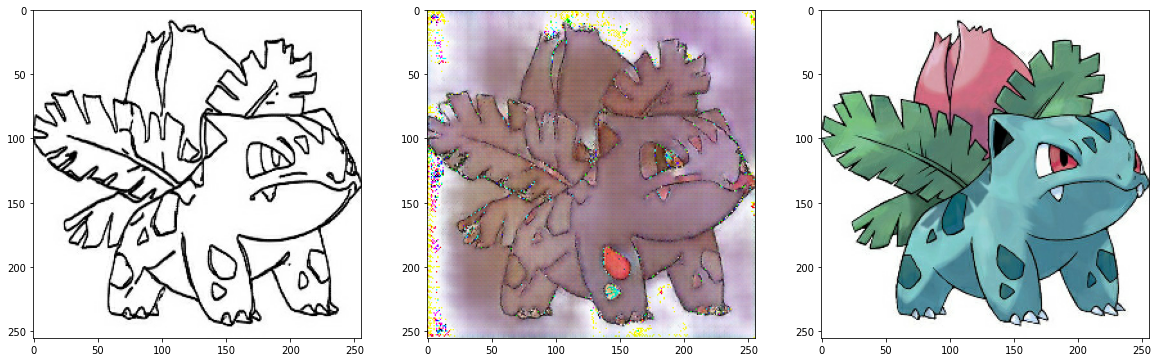

In [30]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

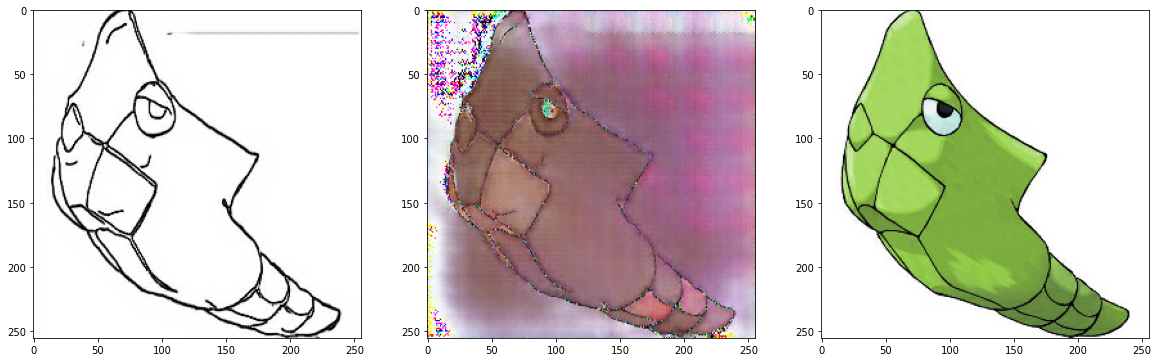

In [31]:
test_ind = 2

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))